In [647]:
#!pip install -qq BorutaShap

In [648]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from lightgbm import LGBMClassifier

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.pipeline import make_pipeline as Ipipe
from itertools import combinations
from imblearn.combine import SMOTEENN

from catboost import Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
import optuna
from optuna.samplers import TPESampler

import category_encoders as ce
from BorutaShap import BorutaShap
import shap

seed = 42
np.random.seed(seed)
%matplotlib inline

In [649]:
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

In [650]:
path = r'Churn_Modelling.csv'
TARGET = 'Exited'

In [651]:
df = pd.read_csv(path)
df.drop('RowNumber', axis=1, inplace=True)
df.set_index('CustomerId', drop=True, inplace=True)
df.drop_duplicates(inplace=True)
df = reduce_memory(df)
df.sample(5)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15687492,Anderson,596,Germany,Male,32,3,96709.070312,2,0,0,41788.371094,0
15736963,Herring,623,France,Male,43,1,0.000000,2,1,1,146379.296875,0
15721730,Amechi,601,Spain,Female,44,4,0.000000,2,1,0,58561.308594,0
15762134,Liang,506,Germany,Male,59,8,119152.101562,2,1,1,170679.734375,0
15648898,Chuang,560,Spain,Female,27,7,124995.976562,1,1,1,114669.789062,0


In [652]:
df.info() # no missing values. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Surname          10000 non-null  category
 1   CreditScore      10000 non-null  int16   
 2   Geography        10000 non-null  category
 3   Gender           10000 non-null  category
 4   Age              10000 non-null  int8    
 5   Tenure           10000 non-null  int8    
 6   Balance          10000 non-null  float32 
 7   NumOfProducts    10000 non-null  int8    
 8   HasCrCard        10000 non-null  int8    
 9   IsActiveMember   10000 non-null  int8    
 10  EstimatedSalary  10000 non-null  float32 
 11  Exited           10000 non-null  int8    
dtypes: category(3), float32(2), int16(1), int8(6)
memory usage: 361.1 KB


In [653]:
df[TARGET].value_counts(normalize=True)  # imbalanced data

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [654]:
df.describe()  # at first glance it doesn't seem there are any significant outliers

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.890625,1.530200,0.70550,0.515100,100090.234375,0.203700
std,96.653299,10.487806,2.892174,62397.406250,0.581654,0.45584,0.499797,57510.492188,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.109375,0.000000
50%,652.000000,37.000000,5.000000,97198.539062,1.000000,1.00000,1.000000,100193.914062,0.000000
75%,718.000000,44.000000,7.000000,127644.238281,2.000000,1.00000,1.000000,149388.253906,0.000000
max,850.000000,92.000000,10.000000,250898.093750,4.000000,1.00000,1.000000,199992.484375,1.000000


In [655]:
df.describe(exclude=['number'])

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


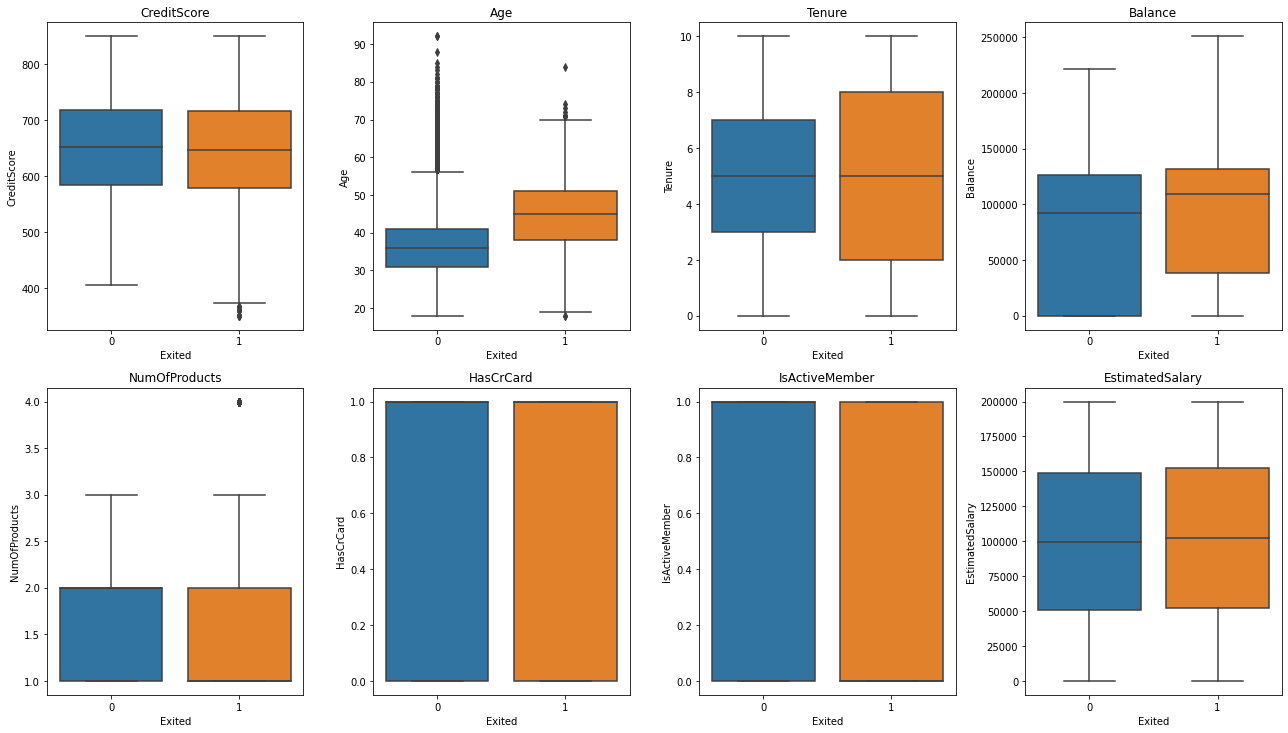

In [656]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(df.select_dtypes(include='number').columns[:-1], 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=df[column], x=df[TARGET], data=df)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

In [657]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

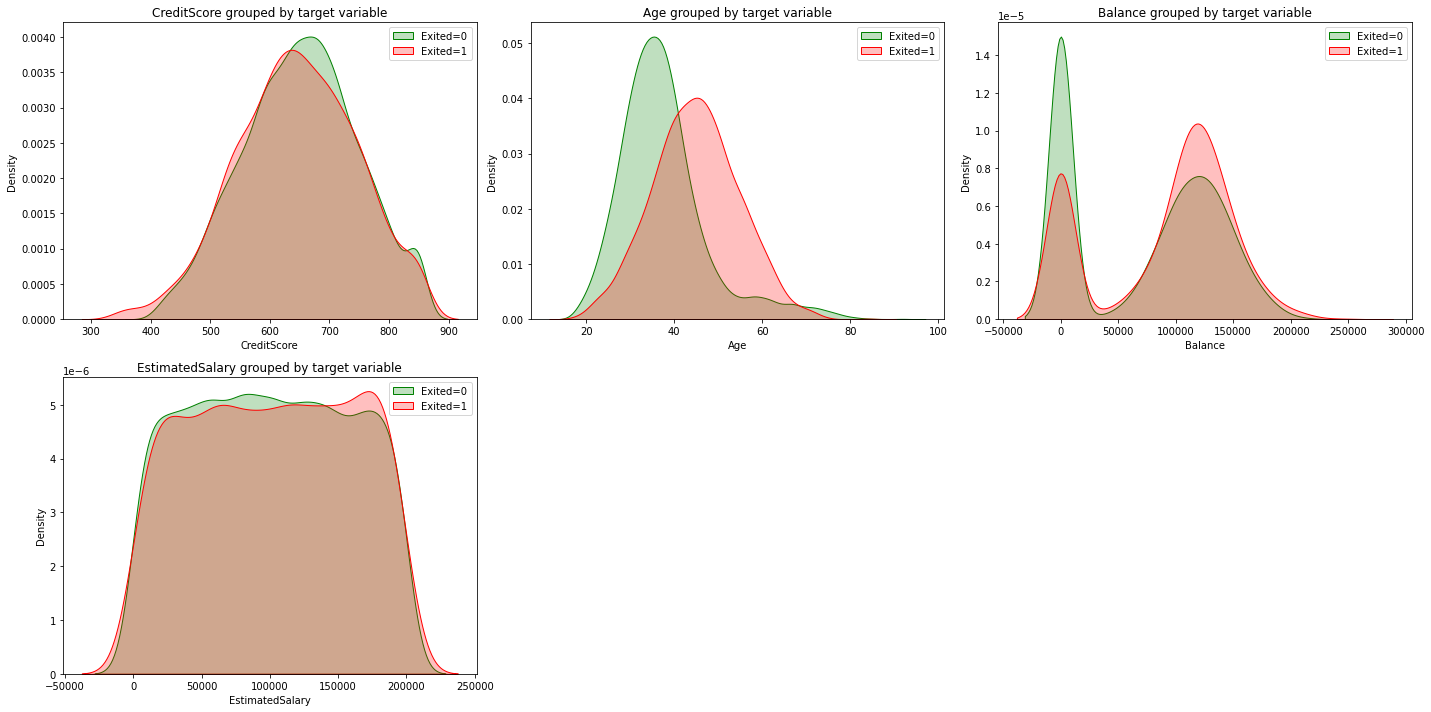

In [658]:
plt.figure(figsize=(20, 10))
for idx, col in enumerate(['CreditScore', 'Age', 'Balance', 'EstimatedSalary'], 1):
    plt.subplot(2, 3, idx)
    feature_with_target_s = df[[col, TARGET]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET] == 1]

    sns.kdeplot(feature_target_0, shade=True, label=f'{TARGET}=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label=f'{TARGET}=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [659]:
from scipy import stats

def categorical_stats(df=df, target=TARGET, alpha=0.05, sample_size=500):
    data = df.copy().sample(sample_size)
    columns_to_analize = data.select_dtypes(include=['category', 'object']).columns
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[target])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature {factor} has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)
        
def statistic_output(*columns, df=df, target=TARGET, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    for column in columns:
        df_sampled = data[[column, target]].sample(sample_size, random_state=1)
        factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
        factor_b = df_sampled.loc[df_sampled[target] == 1][column]
        var_a, var_b = factor_a.var(), factor_b.var()   
        _, pvalue = stats.shapiro(df_sampled[column])
        if pvalue >= alpha:
            _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
        else:
            if len(factor_a) == 0 or len(factor_b) == 0:
                continue
            _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
        if pvalue < alpha:
            print(f'Factor "{column}" has statistical impact on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}).')
        else:
            print(f'Factor "{column}" does not affect target.')

In [660]:
categorical_stats()  # as expected Surname and Gender are statistically weak, we'll return here in feature selection part

Surname
Geography
Feature Geography has statistical impact on target. P-value: 0.040886
Gender
Feature Gender has statistical impact on target. P-value: 0.002068
Statistically weak categorical features:  Surname


In [661]:
stat_num_columns = df.select_dtypes(include='number').columns[:-1].tolist()
statistic_output(*stat_num_columns)
# WoW! as for boxplots and stat test it seems like CreditScore has no statistical impact on target

Factor "CreditScore" does not affect target.
Factor "Age" has statistical impact on target (var_a: 93.88, var_b: 100.22).
Factor "Tenure" does not affect target.
Factor "Balance" has statistical impact on target (var_a: 3915269120.00, var_b: 3913344000.00).
Factor "NumOfProducts" has statistical impact on target (var_a: 0.25, var_b: 0.63).
Factor "HasCrCard" does not affect target.
Factor "IsActiveMember" has statistical impact on target (var_a: 0.25, var_b: 0.25).
Factor "EstimatedSalary" does not affect target.


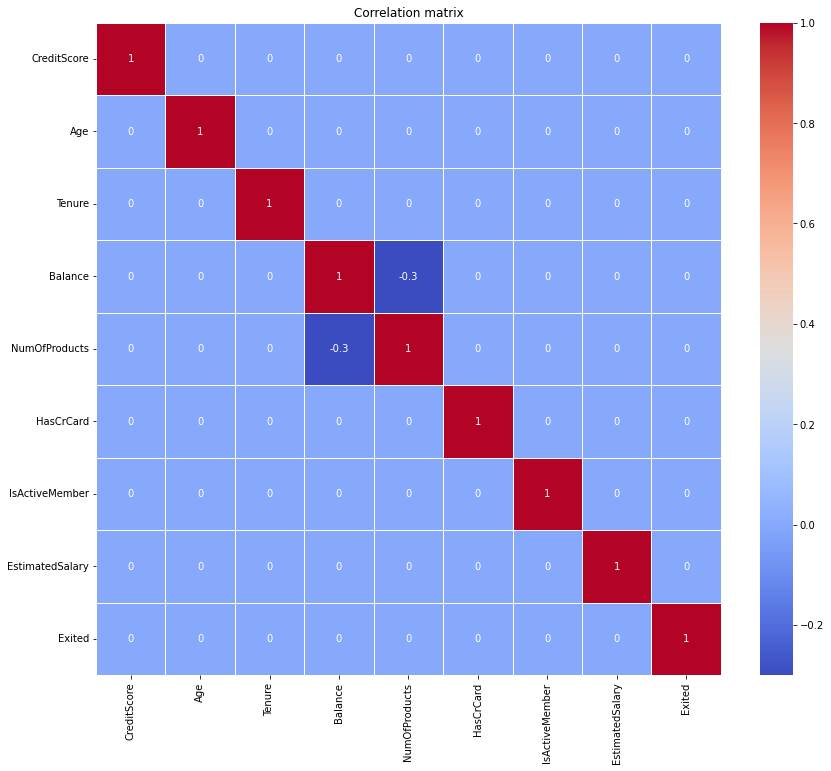

In [662]:
# for linear models: NO significant linear correlations (and as for 'kendall' - not at all)
plt.figure(figsize = (14,12))
corr_matrix = df.corr(method='pearson')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

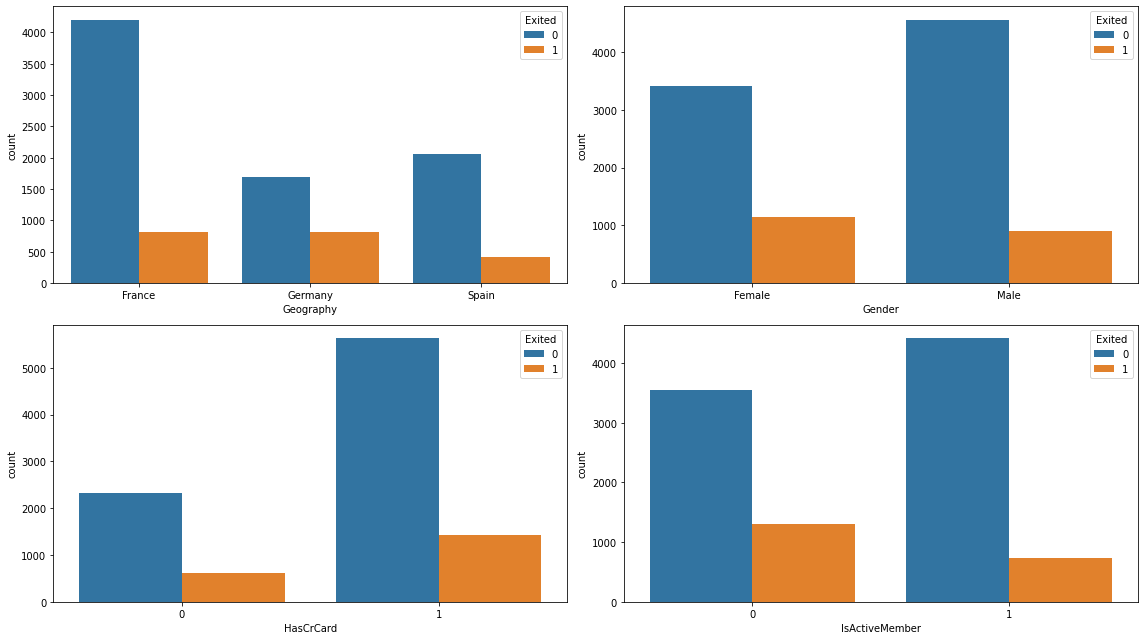

In [663]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 9))
sns.countplot(x='Geography', hue=TARGET, data=df, ax=axarr[0][0])
sns.countplot(x='Gender', hue=TARGET, data=df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue=TARGET, data=df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue=TARGET, data=df, ax=axarr[1][1])
plt.tight_layout()
plt.show()
# France is the leader of customers

#### Feature engineering

In [664]:
df['Age_cut'] = pd.cut(df.Age, bins=np.linspace(0, df.Age.max(), 4), labels=[1,2,3])
df['Salary_cut'] = pd.cut(df.EstimatedSalary, bins=np.linspace(0, df.EstimatedSalary.max(), 10), labels=False)
df['Counts'] = (df.NumOfProducts + df.HasCrCard) * df.IsActiveMember
df['Balance_to_Salary_ratio'] = df.Balance / (df.EstimatedSalary + 1)

#### modeling

In [665]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_bins = None
        self.salary_bins = None
        
    def fit(self, X, y=None):
        self.age_bins = np.linspace(0, X.Age.max(), 4)
        self.salary_bins = np.linspace(0, X.EstimatedSalary.max()+1, 10)
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_.drop('RowNumber', axis=1, inplace=True)
        X_.drop_duplicates(inplace=True)
        X_ = reduce_memory(X_)
        X_.Gender = X_.Gender.map({'Female': 0, 'Male': 1})
        
        X_['Age_cut'] = pd.cut(X_.Age, bins=self.age_bins, labels=[1,2,3])
        X_['Salary_cut'] = pd.cut(X_.EstimatedSalary, bins=self.salary_bins, labels=False)
        X_['Counts'] = (X_.NumOfProducts + X_.HasCrCard) * X_.IsActiveMember
        X_['Balance_to_Salary_ratio'] = X_.Balance / (X_.EstimatedSalary + 1)
        
        return X_

base_boruta_params = {'model': LGBMClassifier(verbose=-1, 
                                              is_unbalance=True, 
                                              random_state=seed), 
                      'importance_measure': 'shap', 
                      'classification': True}

class BorutaSelection(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.selector = BorutaShap(**kwargs)
        
    def fit(self, X, y=None):
        self.selector.fit(X, y, n_trials=20, sample=True, verbose=False)
        return self
    
    def transform(self, X):
        drop_columns = self.selector.features_to_remove
        return X.drop(drop_columns, axis=1)
    
class CatBoostSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_select=13, steps=2, plot=True):
        self.columns = None
        self.train_pool = None
        self.valid_pool = None
        self.num_select = num_select
        self.steps = steps
        self.plot = plot
        
    def fit(self, X, y=None):
        cat_cols = X.select_dtypes(include='category').columns.tolist()
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)
        self.train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        self.valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
        summary = self.select_features(EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=self.steps, 
                                       num_select=self.num_select)
        self.columns = summary['selected_features_names']
        return self
    
    def transform(self, X):
        return X[self.columns]
    
    def select_features(self, algorithm: EFeaturesSelectionAlgorithm, steps: int = 2, num_select=13):
        model = CatBoostClassifier(iterations=200, auto_class_weights='Balanced', random_seed=seed)
        summary = model.select_features(
            self.train_pool,
            eval_set=self.valid_pool,
            features_for_select=list(range(self.train_pool.num_col())),
            num_features_to_select=num_select,
            steps=steps,
            algorithm=algorithm,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=self.plot
        )
        return summary
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class MakeDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [666]:
df = pd.read_csv(path)
df.set_index('CustomerId', drop=True, inplace=True)

X, y = df.drop(TARGET, axis=1), df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)

In [667]:
high_cardinality_cols = ['Surname',]
low_cadinality_cols = ['Geography',]
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
                  'Age_cut', 'Salary_cut', 'Counts', 'Balance_to_Salary_ratio']
bin_num_cols = ['HasCrCard', 'IsActiveMember', 'Gender']
base_columns = high_cardinality_cols + [f'Geography_{cat}' for cat in X.Geography.unique()] + numerical_cols + bin_num_cols
###
high_pipe = make_pipeline(FeatureSelector(high_cardinality_cols), 
                          ce.cat_boost.CatBoostEncoder(a=3, random_state=seed, return_df=True))
low_pipe = make_pipeline(FeatureSelector(low_cadinality_cols),
                         ce.one_hot.OneHotEncoder(return_df=True))
bin_num_pipe = make_pipeline(FeatureSelector(bin_num_cols),)
num_pipe = make_pipeline(FeatureSelector(numerical_cols),
                         StandardScaler(),
                         MakeDataFrame(numerical_cols))

transformer = make_union(high_pipe,
                         low_pipe,
                         bin_num_pipe,
                         num_pipe
                         )
###
col_transformer = make_column_transformer((ce.cat_boost.CatBoostEncoder(a=3, random_state=seed, return_df=True), high_cardinality_cols),
                                          (ce.one_hot.OneHotEncoder(return_df=True), low_cadinality_cols),
                                          (StandardScaler(), numerical_cols), 
                                          remainder='passthrough')

pipe = Ipipe(Preprocessor(),
             col_transformer,
             MakeDataFrame(base_columns),
             BorutaSelection(**base_boruta_params), # not the best as we use tree explainer with linear model
             SMOTEENN(sampling_strategy='auto', random_state=seed),
             PolynomialFeatures(degree=2, interaction_only=True),
             LogisticRegression(class_weight='balanced', random_state=seed)
             ).fit(X_train, y_train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [668]:
base_mod_train = pipe.predict(X_train)
base_mod_test = pipe.predict(X_test)
base_train_proba = pipe.predict_proba(X_train)[:,1]
base_test_proba = pipe.predict_proba(X_test)[:,1]

report(y_train, base_mod_train, y_test, base_mod_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.913     0.732     0.813      5972
           1      0.410     0.726     0.524      1528

    accuracy                          0.731      7500
   macro avg      0.661     0.729     0.668      7500
weighted avg      0.810     0.731     0.754      7500

Test
               precision    recall  f1-score   support

           0      0.916     0.731     0.813      1991
           1      0.412     0.737     0.528       509

    accuracy                          0.732      2500
   macro avg      0.664     0.734     0.671      2500
weighted avg      0.813     0.732     0.755      2500

Train ROC_AUC: 0.797, Test ROC_AUC: 0.802
Confusion Matrix 
 col_0      0    1
Exited           
0       1455  536
1        134  375


In [669]:
precision, recall, thresholds = precision_recall_curve(y_test, base_test_proba)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.757, F-score: 0.560, Recall: 0.568, Precision: 0.553.


#### CatBoost

In [670]:
df = pd.read_csv(path)
df.set_index('CustomerId', drop=True, inplace=True)

X, y = df.drop(TARGET, axis=1), df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1000, shuffle=True, stratify=y_train, 
                                                     random_state=seed)
print(f'Train size: {len(X_train)}, validation size: {len(X_valid)}, test size: {len(X_test)}.')

Train size: 7000, validation size: 1000, test size: 2000.


In [671]:
cat_pipe = make_pipeline(Preprocessor(),
                         CatBoostSelector(num_select=10, steps=4),
                        )

In [672]:
X_train = cat_pipe.fit_transform(X_train, y_train)
X_valid = cat_pipe.transform(X_valid)
X_test = cat_pipe.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [673]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [674]:
params_model = {
    'eval_metric': 'F1', 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Ordered',
    'use_best_model': True,
    'random_seed': seed,
    }

In [675]:
cat_model = CatBoostClassifier(verbose=0).fit(train_pool, eval_set=valid_pool)
cat_train_pred = cat_model.predict(X_train)
cat_test_pred = cat_model.predict(X_test)
cat_train_proba = cat_model.predict_proba(X_train)[:,1]
cat_test_proba = cat_model.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.882     0.968     0.923      5574
           1      0.800     0.494     0.611      1426

    accuracy                          0.872      7000
   macro avg      0.841     0.731     0.767      7000
weighted avg      0.865     0.872     0.860      7000

Test
               precision    recall  f1-score   support

           0      0.880     0.968     0.922      1593
           1      0.794     0.482     0.599       407

    accuracy                          0.869      2000
   macro avg      0.837     0.725     0.761      2000
weighted avg      0.862     0.869     0.856      2000

Train ROC_AUC: 0.895, Test ROC_AUC: 0.875
Confusion Matrix 
 col_0      0    1
Exited           
0       1542   51
1        211  196


In [676]:
precision, recall, thresholds = precision_recall_curve(y_test, cat_test_proba)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.285, F-score: 0.651, Recall: 0.698, Precision: 0.609.


In [677]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    #'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                    #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    #'max_leaves': trial.suggest_int('max_leaves', 5, 64),
                    }
    param_trials.update(params_model)
    #if param_trials['grow_policy'] == 'SymmetricTree':
    #    param_trials['min_data_in_leaf'] = None
    #    param_trials['max_leaves'] = None
    #if param_trials['grow_policy'] == 'Depthwise':
    #    param_trials['max_leaves'] = None
    #if param_trials['grow_policy'] != 'SymmetricTree':
    #    param_trials['boosting_type'] = 'Plain'
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict(X_valid)
    score = f1_score(y_valid, y_pred)
    
    return score

In [678]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=160, timeout=6000, n_jobs=-1)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Number of completed trials: 160
Best trial
Best score: 0.691358024691358
Best params
depth: 6
learning_rate: 0.4459325564530097
l2_leaf_reg: 1.7401737456912696
bagging_temperature: 2.7477633242286292
subsample: 0.885060290644065
colsample_bylevel: 0.8639331815803044
boosting_type: Ordered
auto_class_weights: SqrtBalanced


In [679]:
params_model = {    
    'eval_metric': 'F1', 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'use_best_model': True,
    'random_seed': seed,
    'depth': 4, 
    'learning_rate': 0.18905265981777902, 
    'l2_leaf_reg': 4.927368361978105, 
    'bagging_temperature': 2.2640277968462534, 
    'subsample': 0.9992916335161026, 
    'colsample_bylevel': 0.7949774988901771, 
    'auto_class_weights': 'SqrtBalanced', 
}

In [680]:
cat_model = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)
cat_train_pred = cat_model.predict(X_train)
cat_test_pred = cat_model.predict(X_test)
cat_train_proba = cat_model.predict_proba(X_train)[:,1]
cat_test_proba = cat_model.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.902     0.919     0.910      5574
           1      0.658     0.608     0.632      1426

    accuracy                          0.856      7000
   macro avg      0.780     0.764     0.771      7000
weighted avg      0.852     0.856     0.854      7000

Test
               precision    recall  f1-score   support

           0      0.902     0.922     0.912      1593
           1      0.667     0.609     0.637       407

    accuracy                          0.859      2000
   macro avg      0.785     0.766     0.774      2000
weighted avg      0.854     0.859     0.856      2000

Train ROC_AUC: 0.875, Test ROC_AUC: 0.868
Confusion Matrix 
 col_0      0    1
Exited           
0       1469  124
1        159  248


In [681]:
precision, recall, thresholds = precision_recall_curve(y_test, cat_test_proba)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.486, F-score: 0.643, Recall: 0.629, Precision: 0.658.


In [682]:
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix]

#### Model selection

In [683]:
from sklearn.model_selection import StratifiedKFold

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

In [684]:
X_fold, X_test, y_fold, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

In [685]:
cat_pipe = make_pipeline(Preprocessor(),
                         CatBoostSelector(num_select=10, steps=4),
                        )
X_fold = cat_pipe.fit_transform(X_fold, y_fold)
X_test = cat_pipe.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [686]:
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=5)
models = []
i = 1
for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    cat = CatBoostClassifier(cat_features=cat_cols, **params_model)

    cat.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    test_labels = cat.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = cat.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = cat.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = cat.predict_proba(X_test)[:,1]
    test_results.append(pred_test)
    thres, fscore = get_best_threshold(y_test, pred_test)
    print(f'Model {i} best fscore: {fscore:.4f}, threshold: {thres:.4f}')
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    models.append(cat)
    i+=1

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=np.ones(5,))

Model 1 best fscore: 0.6447, threshold: 0.4516
              precision    recall  f1-score   support

           0      0.900     0.915     0.908      1593
           1      0.644     0.604     0.624       407

    accuracy                          0.852      2000
   macro avg      0.772     0.760     0.766      2000
weighted avg      0.848     0.852     0.850      2000
 
Model 2 best fscore: 0.6541, threshold: 0.4912
              precision    recall  f1-score   support

           0      0.905     0.923     0.914      1593
           1      0.673     0.622     0.646       407

    accuracy                          0.862      2000
   macro avg      0.789     0.772     0.780      2000
weighted avg      0.858     0.862     0.859      2000
 
Model 3 best fscore: 0.6370, threshold: 0.4788
              precision    recall  f1-score   support

           0      0.903     0.918     0.910      1593
           1      0.656     0.614     0.635       407

    accuracy                          0

In [687]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')

train mean accuracy: 0.8590, test accuracy: 0.8585
train mean f1: 0.6363, test f1: 0.6386
train mean auc: 0.8747, test auc: 0.8738


In [688]:
cat_best = models[1]
thres = 0.4912

test_preds = cat_best.predict(X_test)
test_probs = cat_best.predict_proba(X_test)[:,1]
print(classification_report(y_test, test_probs>=thres, digits=3))

              precision    recall  f1-score   support

           0      0.909     0.918     0.914      1593
           1      0.667     0.639     0.652       407

    accuracy                          0.862      2000
   macro avg      0.788     0.779     0.783      2000
weighted avg      0.859     0.862     0.860      2000



In [689]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


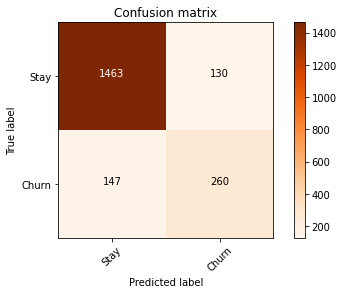

In [690]:
plot_confusion_matrix(confusion_matrix(y_test, test_probs>=thres), classes=['Stay', 'Churn'])

Здесь используется несколько модифицированный вариант. Считаем, что доход в 2 у.е. мы получаем с каждого клиента, который остался с нами (TN+FP), и с каждого клиента, которого нам удалось удержать (TP) благодаря рекламе (затраты на рекламу TP + FP). При этом расцениваем отток клиента как экономичкскую потерю в 2 у.е. (упущенная выгода). Таким образом, считаем прибыль как общий доход (TN+FP+TP-FN) минус расходы на рекламную кампанию (TP + FP).

In [691]:
advertisement_cost = 1
churn_cost = 2  # if customer churns - loss = 2, if stays income += 2
cm = confusion_matrix(y_test, test_probs>=thres)
TN, TP, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
print(f'Losses with no ML: {(TP+FN)*churn_cost}')
print(f'Losses with ML: {(TP+FP)*advertisement_cost + FN * churn_cost}')
print('='*60)
print(f'Income with no ML and no adv.: {(TN + FP - FN - FP)*churn_cost}')
print(f'Income with no ML and adv.: {(FN+FP+TN+TP)*(churn_cost - advertisement_cost)}')
print(f'Income with ML: {(TN + FP + TP - FN)*churn_cost - (TP + FP)*advertisement_cost}')

Losses with no ML: 814
Losses with ML: 684
Income with no ML and no adv.: 2632
Income with no ML and adv.: 2000
Income with ML: 3022


#### Economic hyperparameter tunning

In [692]:
def business_metric(y_true, y_score, n=20, churn_cost=2, adv_cost=1):
    best_income = -np.inf
    best_thres = 0.
    for thres in np.linspace(0, 1, n):
        cm = confusion_matrix(y_true, y_score>=thres)
        TN, TP, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
        metric = (TN + FP + TP - FN)*churn_cost - (TP + FP)*adv_cost
        if metric > best_income:
            best_income = metric
            best_thres = thres
    return best_income, best_thres

business_metric(y_test, test_probs, n=50)

(3025, 0.4693877551020408)

In [693]:
_, thres = business_metric(y_test, test_probs, n=50)
print(classification_report(y_test, test_probs>=thres, digits=3))

              precision    recall  f1-score   support

           0      0.911     0.909     0.910      1593
           1      0.647     0.654     0.650       407

    accuracy                          0.857      2000
   macro avg      0.779     0.781     0.780      2000
weighted avg      0.858     0.857     0.857      2000



### Из урока

In [694]:
retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

130

In [695]:
def business_metric(y_true, y_score, n=20, churn_cost=2, adv_cost=1):
    best_income = -np.inf
    best_thres = 0.
    for thres in np.linspace(0, 1, n):
        cm = confusion_matrix(y_true, y_score>=thres)
        metric = cm[1,1]*churn_cost - np.sum(cm[:, 1])*adv_cost
        if metric > best_income:
            best_income = metric
            best_thres = thres
    return best_income, best_thres

business_metric(y_test, test_probs, n=1000)

(149, 0.6866866866866866)

In [696]:
# select 30% of data to compare with lesson result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2500, shuffle=True, stratify=y, random_state=seed)
X_test = cat_pipe.transform(X_test)
test_probs = cat_best.predict_proba(X_test)[:,1]
business_metric(y_test, test_probs, n=1000)  # NOTE: the threshold changed - possible reason -> more data provided

(196, 0.5645645645645646)

#### catboost+optuna+custom eval metric для модифицированной бизнес метрики, затем для метрики, предложенной на уроке

In [697]:
churn_cost = 2
adv_cost = 1

class Profit:
    @staticmethod
    def get_profit(y_true, y_pred):
        TN, TP, FP, FN = confusion_matrix(y_true, y_pred>=0.5).ravel()
        loss = (TN + FP + TP - FN)*churn_cost - (TP + FP)*adv_cost
        return loss
    
    def is_max_optimal(self):
        return True # greater is better

    def evaluate(self, approxes, target, weight):            
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        y_true = np.array(target).astype(int)
        approx = approxes[0]
        score = self.get_profit(y_true, approx)
        return score, 1

    def get_final_error(self, error, weight):
        return error
    
def business_metric(y_true, y_score, n=20, churn_cost=2, adv_cost=1):
    best_income = -np.inf
    best_thres = 0.
    for thres in np.linspace(0, 1, n):
        cm = confusion_matrix(y_true, y_score>=thres)
        TN, TP, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
        metric = (TN + FP + TP - FN)*churn_cost - (TP + FP)*adv_cost
        if metric > best_income:
            best_income = metric
            best_thres = thres
    return best_income, best_thres

In [698]:
# optuna hyperparams with new metric to maximize
params_model = {
    'eval_metric': 'F1',#Profit(), 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Ordered',
    'use_best_model': True,
    'random_seed': seed,
    }

In [699]:
df = pd.read_csv(path)
df.set_index('CustomerId', drop=True, inplace=True)

X, y = df.drop(TARGET, axis=1), df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1000, shuffle=True, stratify=y_train, 
                                                     random_state=seed)
print(f'Train size: {len(X_train)}, validation size: {len(X_valid)}, test size: {len(X_test)}.')

Train size: 7000, validation size: 1000, test size: 2000.


In [700]:
X_train = cat_pipe.fit_transform(X_train, y_train)
X_valid = cat_pipe.transform(X_valid)
X_test = cat_pipe.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [701]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [702]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    }
    param_trials.update(params_model)
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score, _ = business_metric(y_valid, y_pred)
    
    return score

In [703]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=160, timeout=6000, n_jobs=-1)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Number of completed trials: 160
Best trial
Best score: 1540.0
Best params
depth: 5
learning_rate: 0.4386745916838472
l2_leaf_reg: 4.694428259809157
bagging_temperature: 1.6621871181377805
subsample: 0.6003792509778497
colsample_bylevel: 0.8243679703433101
boosting_type: Ordered
auto_class_weights: SqrtBalanced


In [704]:
params_model = {    
    'eval_metric': 'F1',# Profit(), 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Ordered',
    'use_best_model': True,
    'random_seed': seed,
    'depth': 9, 
    'learning_rate': 0.4878497345275222, 
    'l2_leaf_reg': 3.8779690807374076, 
    'bagging_temperature': 2.801185080626141, 
    'subsample': 0.800952214628959, 
    'colsample_bylevel': 0.8091306682682988, 
    'auto_class_weights': 'SqrtBalanced', 
}

In [705]:
cat_model = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)
cat_train_pred = cat_model.predict(X_train)
cat_test_pred = cat_model.predict(X_test)
cat_train_proba = cat_model.predict_proba(X_train)[:,1]
cat_test_proba = cat_model.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)
business_metric(y_test, cat_test_proba, n=1000)

Train
               precision    recall  f1-score   support

           0      0.900     0.926     0.913      5574
           1      0.673     0.600     0.634      1426

    accuracy                          0.859      7000
   macro avg      0.787     0.763     0.774      7000
weighted avg      0.854     0.859     0.856      7000

Test
               precision    recall  f1-score   support

           0      0.901     0.920     0.911      1593
           1      0.660     0.604     0.631       407

    accuracy                          0.856      2000
   macro avg      0.780     0.762     0.771      2000
weighted avg      0.852     0.856     0.854      2000

Train ROC_AUC: 0.877, Test ROC_AUC: 0.871
Confusion Matrix 
 col_0      0    1
Exited           
0       1466  127
1        161  246


(3021, 0.34434434434434436)

#### Try again

In [706]:
X_fold, X_test, y_fold, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
cat_pipe = make_pipeline(Preprocessor(),
                         CatBoostSelector(num_select=10, steps=4),
                        )
X_fold = cat_pipe.fit_transform(X_fold, y_fold)
X_test = cat_pipe.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [707]:
params_model = {    
    'eval_metric': 'F1', 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'use_best_model': True,
    'random_seed': seed,
    'depth': 4, 
    'learning_rate': 0.18905265981777902, 
    'l2_leaf_reg': 4.927368361978105, 
    'bagging_temperature': 2.2640277968462534, 
    'subsample': 0.9992916335161026, 
    'colsample_bylevel': 0.7949774988901771, 
    'auto_class_weights': 'SqrtBalanced', 
}

In [708]:
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=5)
models = []
i = 1
for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    cat = CatBoostClassifier(cat_features=cat_cols, **params_model)

    cat.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    test_labels = cat.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = cat.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = cat.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = cat.predict_proba(X_test)[:,1]
    test_results.append(pred_test)
    thres, fscore = get_best_threshold(y_test, pred_test)
    business_score, busy_thres = business_metric(y_test, pred_test, n=100)
    print(f'Model {i} best fscore: {fscore:.4f}, threshold: {thres:.4f}')
    print(f'Model {i} best businessM: {business_score}, threshold: {busy_thres:.4f}')
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    models.append(cat)
    i+=1

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=np.ones(5,))

Model 1 best fscore: 0.6447, threshold: 0.4516
Model 1 best businessM: 3024, threshold: 0.4545
              precision    recall  f1-score   support

           0      0.900     0.915     0.908      1593
           1      0.644     0.604     0.624       407

    accuracy                          0.852      2000
   macro avg      0.772     0.760     0.766      2000
weighted avg      0.848     0.852     0.850      2000
 
Model 2 best fscore: 0.6541, threshold: 0.4912
Model 2 best businessM: 3021, threshold: 0.4646
              precision    recall  f1-score   support

           0      0.905     0.923     0.914      1593
           1      0.673     0.622     0.646       407

    accuracy                          0.862      2000
   macro avg      0.789     0.772     0.780      2000
weighted avg      0.858     0.862     0.859      2000
 
Model 3 best fscore: 0.6370, threshold: 0.4788
Model 3 best businessM: 3024, threshold: 0.4040
              precision    recall  f1-score   support

    

In [709]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')

train mean accuracy: 0.8590, test accuracy: 0.8585
train mean f1: 0.6363, test f1: 0.6386
train mean auc: 0.8747, test auc: 0.8738


Confusion matrix, without normalization


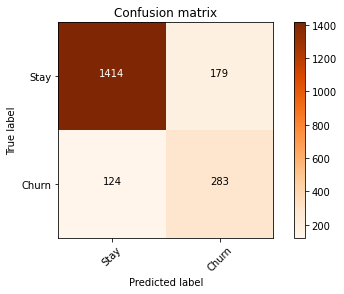

In [710]:
best_cat = models[-1]
test_probs = best_cat.predict_proba(X_test)[:,1]
thres = 0.4242
plot_confusion_matrix(confusion_matrix(y_test, test_probs>=thres), classes=['Stay', 'Churn'])
# we actually decreased FN with respect to FP

In [711]:
business_metric(y_test, test_probs, n=100)  # besides DS threshold is almost the same as business

(3042, 0.42424242424242425)

#### As for now the best business result was achieved with CatBoostModel, evaluation=F1 and tunning with DS metrics, and then calibrating by business_meric(). Profit: 3042. Custom eval_metric or tunning with business_metric didn't improve our income.

### Из урока

In [712]:
# from lesson
cnf_matrix = confusion_matrix(y_test, test_probs>=thres)
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

104

In [713]:
# atempt to optimize model with lesson business metric
# we make similar steps to let the notebook run from first to last cell continously
churn_cost = 2
adv_cost = 1

class Profit:
    @staticmethod
    def get_profit(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred>=0.5)
        loss = cm[1,1]*churn_cost - np.sum(cm[:,1])*adv_cost
        return loss
    
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):            
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        y_true = np.array(target).astype(int)
        approx = approxes[0]
        score = self.get_profit(y_true, approx)
        return score, 1

    def get_final_error(self, error, weight):
        return error
    
def business_metric(y_true, y_score, n=20, churn_cost=2, adv_cost=1):
    best_income = -np.inf
    best_thres = 0.
    for thres in np.linspace(0, 1, n):
        cm = confusion_matrix(y_true, y_score>=thres)
        metric = cm[1,1]*churn_cost - np.sum(cm[:, 1])*adv_cost
        if metric > best_income:
            best_income = metric
            best_thres = thres
    return best_income, best_thres

In [714]:
params_model = {
    'eval_metric': 'F1', #Profit(), 
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Ordered',
    'use_best_model': True,
    'random_seed': seed,
    }

In [715]:
df = pd.read_csv(path)
df.set_index('CustomerId', drop=True, inplace=True)

X, y = df.drop(TARGET, axis=1), df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1000, shuffle=True, stratify=y_train, 
                                                     random_state=seed)
print(f'Train size: {len(X_train)}, validation size: {len(X_valid)}, test size: {len(X_test)}.')

Train size: 7000, validation size: 1000, test size: 2000.


In [716]:
X_train = cat_pipe.fit_transform(X_train, y_train)
X_valid = cat_pipe.transform(X_valid)
X_test = cat_pipe.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [717]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [718]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    }
    param_trials.update(params_model)
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict(X_valid)
    score = precision_score(y_valid, y_pred)
    
    return score

In [719]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=160, timeout=6000, n_jobs=-1)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

Number of completed trials: 160
Best trial
Best score: 0.7724137931034483
Best params
depth: 4
learning_rate: 0.08227297476242304
l2_leaf_reg: 2.7467870092771824
bagging_temperature: 2.85786737690797
subsample: 0.5335878589594624
colsample_bylevel: 0.8436235974319286
boosting_type: Ordered
auto_class_weights: SqrtBalanced


In [720]:
params_model = {    
    'eval_metric': 'F1', # precision here not improving
    'iterations': 2000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'use_best_model': True,
    'random_seed': seed,
    'depth': 6, 
    'learning_rate': 0.16690447781991957, 
    'l2_leaf_reg':  2.485600542223607, 
    'bagging_temperature':2.4389441655758537, 
    'subsample':  0.6917746964337574, 
    'colsample_bylevel': 0.7231560397888404, 
    'auto_class_weights': 'SqrtBalanced', 
}

In [721]:
cat_model = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)
cat_train_pred = cat_model.predict(X_train)
cat_test_pred = cat_model.predict(X_test)
cat_train_proba = cat_model.predict_proba(X_train)[:,1]
cat_test_proba = cat_model.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)
business_metric(y_test, cat_test_proba, n=1000)

Train
               precision    recall  f1-score   support

           0      0.900     0.925     0.913      5574
           1      0.672     0.600     0.634      1426

    accuracy                          0.859      7000
   macro avg      0.786     0.762     0.773      7000
weighted avg      0.854     0.859     0.856      7000

Test
               precision    recall  f1-score   support

           0      0.899     0.931     0.915      1593
           1      0.686     0.590     0.634       407

    accuracy                          0.862      2000
   macro avg      0.792     0.760     0.774      2000
weighted avg      0.855     0.862     0.858      2000

Train ROC_AUC: 0.878, Test ROC_AUC: 0.870
Confusion Matrix 
 col_0      0    1
Exited           
0       1483  110
1        167  240


(153, 0.6456456456456456)

Confusion matrix, without normalization


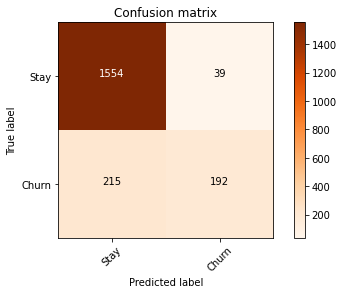

In [722]:
test_probs = cat_model.predict_proba(X_test)[:,1]
thres = 0.6456456456456456
plot_confusion_matrix(confusion_matrix(y_test, test_probs>=thres), classes=['Stay', 'Churn'])

In [723]:
business_metric(y_test, test_probs, n=1000)

(153, 0.6456456456456456)

In [724]:
print(classification_report(y_test, test_probs>=thres, digits=3))

              precision    recall  f1-score   support

           0      0.878     0.976     0.924      1593
           1      0.831     0.472     0.602       407

    accuracy                          0.873      2000
   macro avg      0.855     0.724     0.763      2000
weighted avg      0.869     0.873     0.859      2000



In [725]:
# select 30% of data to compare with lesson result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2500, shuffle=True, stratify=y, random_state=seed)
X_test = cat_pipe.transform(X_test)
test_probs = cat_model.predict_proba(X_test)[:,1]
business_metric(y_test, test_probs, n=1000)

(194, 0.6116116116116116)

Confusion matrix, without normalization


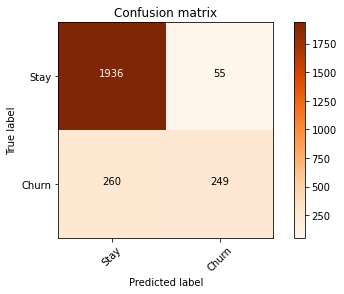

In [726]:
plot_confusion_matrix(confusion_matrix(y_test, test_probs>=thres), classes=['Stay', 'Churn'])

### Оставим модель (для варианта из урока), оптимизированную на DS метриках (F1), проводя затем калибровку по порогу на тестовой выборке для получения оптимального бизнес-результата